# Prerequisites

In [ ]:
# Install dependencies
!pip install skl2onnx onnxruntime

In [1]:
# Mount drive - requres authentication
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Navigate to the following folder - assummes the sensor_data.db contained within
%cd /content/drive/MyDrive/Imperial_assessment_sensors/

/content/drive/MyDrive/Imperial_assessment_sensors


In [3]:
# Initialise the database from the file
import sqlite3
conn = sqlite3.connect('sensor_data.db')
cursor = conn.cursor()

In [4]:
# Connect to the SQLite database
conn = sqlite3.connect('sensor_data.db')
cursor = conn.cursor()

# Fetch and display the schema of the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", tables)

# Display schema of each table
for table_name in tables:
    table_name = table_name[0]  # get the table name
    schema = cursor.execute(f"PRAGMA table_info({table_name})").fetchall()
    print(f"Schema of {table_name}:")
    for column_info in schema:
        print(column_info)

# conn.close()

Tables in the database: [('homes',), ('motion',)]
Schema of homes:
(0, 'id', 'TEXT', 0, None, 0)
(1, 'multiple_occupancy', 'INTEGER', 0, None, 0)
Schema of motion:
(0, 'id', 'TEXT', 0, None, 0)
(1, 'home_id', 'TEXT', 0, None, 0)
(2, 'datetime', 'TEXT', 0, None, 0)
(3, 'location', 'TEXT', 0, None, 0)


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Query a table and load into a DataFrame
query = "SELECT * FROM homes"  # Replace with your table name
homes_df = pd.read_sql_query(query, conn)

# Show the "homes" DataFrame
homes_df

,id,multiple_occupancy
0,dc922bd9bf8a2a9437642fe0dce9dcaa,0
1,d40fc88629271da7b5833ed3f3222d17,1
2,3fb064da180f02862063eca8e3b609c0,1
3,16d71b9c46d9abd765bf395818efe527,0
4,458264665736fd26184a8ea5641e6c48,1
...,...,...
101,dbe580ed60d7c329931d98a0e2ad0ea3,1
102,04a16138cd7e0fa768858ff7c02856d8,1
103,62c8145530aca30cb0455dc386c0a9d6,1
104,3a5cc5ac41ab3b18b63d6d8366e30fb0,1


In [7]:
# Query a table and load into a DataFrame
query = "SELECT * FROM motion"  # Replace with your table name
motion_df = pd.read_sql_query(query, conn)

# Show the "motion" DataFrame
motion_df

,id,home_id,datetime,location
0,e41218b439d933a1cd9ad158f78e9198,205c42ec747e2db13cb92087a99433f1,2024-01-01 00:00:10+00,lounge
1,92d48d869ae50b0764cfb8d70494f618,7d2f2e0a9e059b4fb8106bb0ad4b8a39,2024-01-01 00:00:17+00,lounge
2,65c18ba64884442dd47c2fd4cf3630e4,44a880cc6fc3a7db3464092f650ae7f1,2024-01-01 00:00:18+00,lounge
3,90d6336d189c929aa50fa08e5aee5f41,49b83fce41b676266b98cd1e095f1c11,2024-01-01 00:00:43+00,lounge
4,6e3d73bed24b95ffdfe5ec017787f039,14328a0b7574e912c2e23d62c9476a07,2024-01-01 00:00:57+00,lounge
...,...,...,...,...
580312,5ec75a93dcc136e6a4c7a4483d60b2ed,3a1f53e2e242bff03301a250135f894b,2024-01-31 23:58:26+00,bathroom1
580313,406c70038a540d29b1e68250d5ed341c,37b99328702f9fdc68c431a4ac450f2e,2024-01-31 23:58:36+00,kitchen
580314,5168c52c3c022d747c81a6e6ce868e3f,3a1f53e2e242bff03301a250135f894b,2024-01-31 23:59:02+00,bedroom1
580315,40cad449e7cef4164b02672e8caff379,2b5ce37a65e82735416d69b987d99fe8,2024-01-31 23:59:09+00,hallway


# Feature Engineering

The features derived from motion sensor data aim to capture the intensity, diversity, and timing of household activities to distinguish between single and multiple occupancy. They analyse total motion events, location diversity, daily active periods, and simultaneous movements to identify patterns typical of single residents, families, or homes with frequent visitors. Additionally, they assess the regularity and variability of activity across different times and days, providing a detailed snapshot of household dynamics.

**1) Motion Counts:**
The total number of motion events detected in a home.

*Higher motion counts could suggest multiple occupants or frequent visitors in single-occupancy homes. Consistently low motion counts are more likely in single-person households without regular visitors.*

**2) Unique Locations:**
he number of distinct locations within a home where motion has been detected.

*More unique locations with activity might indicate multiple occupants using different parts of the house or a single occupant with visitors using separate areas.*

**3) Average Active Hours:**
The average number of hours per day during which motion is detected, calculated from the first to the last motion event of each day.

*Longer active hours might suggest multiple people with varying schedules, while shorter and more consistent active hours could indicate a single occupant.*

**4) Simultaneous Activity Count:**
Counts instances where motion is detected in different locations within a very short time span (e.g., less than 2 seconds), suggesting simultaneous movement in multiple locations.

*High counts are strong indicators of multiple occupancy or, in single-occupancy homes, the presence of visitors moving around simultaneously.*

**5) Weekend-Weekday Activity Ratio:**
The ratio of motion events on weekends to weekdays, normalized by the number of days.

*A higher ratio might suggest occupants that spend more time at home on weekends, possibly indicating families. A lower or more balanced ratio could imply a single occupant with a consistent daily routine.*

**6) High Frequency Visit Days:**
Days with motion counts significantly higher than the average, suggesting unusually high activity.

*Frequent high activity days may suggest multiple occupants or frequent visitors in otherwise single-occupancy homes.*

**7) Evening and Night Activity Ratio:**
The ratio of motion events during evening and night hours to total daily motion events.

*Increased activity during these hours could indicate multiple occupants with different schedules or a single occupant with visitors during these times.*

**8) Temporal Entropy:**
Measures the randomness in the distribution of daily motion events. High entropy indicates irregular activity patterns.

*High entropy could suggest multiple occupants with varied schedules, while low entropy might indicate a single occupant with a regular routine.*

**9) Average Location Transitions:**
The average number of times occupants move from one location to another within the home each day.

*Frequent transitions could indicate a dynamic household with multiple occupants or active visitors.*

**10) Average Duration of High Activity Periods:**
Average length of periods with consecutive motion events close together in time.

*Longer durations of high activity could reflect multiple occupants engaging in activities together or hosting visitors.*

In [9]:
import numpy as np

# Merge dataframes on home_id
merged_df = pd.merge(motion_df, homes_df, left_on='home_id', right_on='id', suffixes=('_motion', '_home'))

# Convert 'datetime' to datetime format
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])

# 1) Calculate 'motion_count' directly within merged_df
motion_counts = merged_df.groupby('home_id').size()

# 2) Number of unique locations per home
unique_locations = merged_df.groupby('home_id')['location'].nunique().rename('unique_locations')

# 3) Active hours (time between first and last motion events each day)
first_last_motion = merged_df.groupby(['home_id', merged_df['datetime'].dt.date]).agg(first_motion=('datetime', 'min'), last_motion=('datetime', 'max'))
first_last_motion.reset_index(inplace=True)
active_hours = (first_last_motion['last_motion'] - first_last_motion['first_motion']).dt.total_seconds().div(3600)
active_hours = active_hours.groupby(first_last_motion['home_id']).mean().rename('average_active_hours')

# 4) Simultaneous activity in different locations
merged_df.sort_values(by=['home_id', 'datetime'], inplace=True)
merged_df['next_location'] = merged_df.groupby('home_id')['location'].shift(-1)
merged_df['next_datetime'] = merged_df.groupby('home_id')['datetime'].shift(-1)
merged_df['time_diff'] = (merged_df['next_datetime'] - merged_df['datetime']).dt.seconds
merged_df['simultaneous_activity'] = (merged_df['time_diff'] < 2) & (merged_df['location'] != merged_df['next_location'])
simultaneous_counts = merged_df.groupby('home_id')['simultaneous_activity'].sum()

# 5) Weekend vs Weekday Activity
weekday_activity = merged_df[merged_df['datetime'].dt.weekday < 5].groupby('home_id').size() / 5  # Normalize by the number of weekdays
weekend_activity = merged_df[merged_df['datetime'].dt.weekday >= 5].groupby('home_id').size() / 2  # Normalize by the number of weekend days
weekend_weekday_ratio = weekend_activity / weekday_activity  # Calculate the ratio of normalized values

# Daily motion counts
daily_motion_counts = merged_df.groupby(['home_id', merged_df['datetime'].dt.date]).size()

# 6) High Frequency Visit Days
mean_daily = daily_motion_counts.groupby('home_id').mean()
std_daily = daily_motion_counts.groupby('home_id').std()
high_freq_visit_days = daily_motion_counts.groupby('home_id').apply(lambda x: ((x - mean_daily[x.name]) > std_daily[x.name]).sum())

# 7) Evening and Night Activity
merged_df['hour'] = merged_df['datetime'].dt.hour
evening_activity = merged_df[(merged_df['hour'] >= 18) & (merged_df['hour'] < 22)].groupby(['home_id', merged_df['datetime'].dt.date]).size()
night_activity = merged_df[(merged_df['hour'] >= 22) | (merged_df['hour'] < 6)].groupby(['home_id', merged_df['datetime'].dt.date]).size()
evening_night_ratio = (evening_activity + night_activity).groupby('home_id').mean() / daily_motion_counts.groupby('home_id').mean()

# 8) Temporal Regularity of Visits
daily_entropy = daily_motion_counts.groupby('home_id').apply(lambda x: -(x / x.sum() * np.log2(x / x.sum() + 1e-10)).sum())

# 9) Location Transition Frequency
merged_df['next_location'] = merged_df.groupby(['home_id', merged_df['datetime'].dt.date])['location'].shift(-1)
location_transitions = merged_df[merged_df['location'] != merged_df['next_location']].groupby(['home_id', merged_df['datetime'].dt.date]).size()
avg_location_transitions = location_transitions.groupby('home_id').mean()

# 10) Duration of High Activity Periods
# Assumption: High activity period is a consecutive series of motion events within short intervals (e.g. 300 seconds)
merged_df['time_diff'] = merged_df.groupby('home_id')['datetime'].diff().dt.total_seconds().fillna(0)
high_activity_periods = merged_df[merged_df['time_diff'] <= 300].groupby(['home_id', merged_df['datetime'].dt.date]).size()
avg_high_activity_duration = high_activity_periods.groupby('home_id').mean()

# Extracting multiple_occupancy labels
multiple_occupancy = merged_df[['home_id', 'multiple_occupancy']].drop_duplicates().set_index('home_id')['multiple_occupancy']

# Combine all features into a single DataFrame
features_df = pd.DataFrame({
    'home_id': unique_locations.index,
    'motion_counts': motion_counts,
    'unique_locations': unique_locations,
    'average_active_hours': active_hours,
    'simultaneous_activity_count': simultaneous_counts,
    'weekend_weekday_ratio': weekend_weekday_ratio,
    'high_freq_visit_days': high_freq_visit_days,
    'evening_night_ratio': evening_night_ratio,
    'temporal_entropy': daily_entropy,
    'avg_location_transitions': avg_location_transitions,
    'avg_high_activity_duration': avg_high_activity_duration,
    'multiple_occupancy': multiple_occupancy
}).fillna(0)  # Handling NaNs just in case

# Resetting index to make home_id a column, not an index
features_df.reset_index(drop=True, inplace=True)

# Print the DataFrame
features_df

,home_id,motion_counts,unique_locations,average_active_hours,simultaneous_activity_count,weekend_weekday_ratio,high_freq_visit_days,evening_night_ratio,temporal_entropy,avg_location_transitions,avg_high_activity_duration,multiple_occupancy
0,0904961f621c9bd03542b43b992ec431,3442,3,12.803109,7,0.818550,4,0.212551,4.904476,28.516129,88.741935,0
1,0f44ff9edd221e417195f4398d2f3853,15303,6,17.903548,121,0.721956,6,0.181337,4.933723,283.387097,463.290323,1
2,14328a0b7574e912c2e23d62c9476a07,15977,8,19.648091,541,0.681655,5,0.285661,4.904638,303.387097,481.903226,1
3,15663392d490688cd4b0e5aa3d5b6ef3,6296,5,19.958403,23,0.801174,2,0.261584,3.943388,155.875000,361.437500,1
4,16d71b9c46d9abd765bf395818efe527,6780,4,14.513459,16,0.891357,4,0.281268,4.938244,82.806452,191.774194,0
5,205c42ec747e2db13cb92087a99433f1,16191,7,22.946129,259,1.025300,5,0.355506,4.926984,274.322581,480.774194,1
6,20a3ebd4470c712d6f6d99908d931e09,7166,3,22.919928,20,1.167349,5,0.354591,4.884538,64.516129,205.677419,0
7,2739e3f7409068a94cf6e3eac643c2e7,20501,4,23.344982,980,0.898482,5,0.228184,4.933175,397.516129,618.161290,1
8,2a035e0f88dd05d3c5e61ebee0531a4c,7377,4,23.115484,95,0.980374,4,0.440956,4.933894,78.225806,211.225806,0
9,2b5ce37a65e82735416d69b987d99fe8,4510,6,22.034552,3,0.918739,4,0.358537,4.938132,36.741935,114.483871,0


# Model training and evaluation

The provided code separates the features and target from the dataset and standardizes the features to prepare for model training. It uses 10-fold stratified cross-validation, ideal for managing unbalanced data by ensuring each fold proportionately represents the class labels, thereby preventing training bias toward the majority class.

Various models, including Logistic Regression, Random Forest, Gradient Boosting, and SVM, are evaluated using the F1 score, a metric that balances precision and recall, making it more suitable than accuracy for datasets with uneven class distributions.

Each model's performance is assessed based on the average F1 score calculated across all validation folds, ensuring that the model's ability to predict the minority class is adequately tested.

Finally, the trained models are converted to ONNX format for interoperability, allowing them to be deployed in different environments without dependency on the original training library.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt


# Separate features and target
X = features_df.drop(columns=['home_id', 'multiple_occupancy'])  # Dropping non-feature columns
y = features_df['multiple_occupancy']  # Target variable

# Standardising the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Prepare stratified cross-validation
random_state = 4
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# A few base-line models to evaluate
models = {
    "Logistic Regression": LogisticRegression(random_state=random_state),
    "Random Forest": RandomForestClassifier(random_state=random_state),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "Support Vector Machine": SVC(random_state=random_state, probability=True)
}

# Evaluate each model using cross-validation
for name, model in models.items():
    f1_scores = []
    for train_index, test_index in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions and evaluate
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred)
        f1_scores.append(score)

    # Calculate average F1 score across all folds
    average_f1_score = np.mean(f1_scores)
    print(f"{name} Average F1 Score: {average_f1_score:.4f}")

    # Convert to ONNX format
    initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]  # Adjust the shape accordingly
    onnx_model = convert_sklearn(model, initial_types=initial_type)

    # Convert to ONNX format and save the ONNX model with the F1 score in the filename
    model_filename = f"{name.replace(' ', '_')}_F1_{average_f1_score:.4f}.onnx"
    with open(model_filename, "wb") as f:
        f.write(onnx_model.SerializeToString())


Logistic Regression Average F1 Score: 0.8106
Random Forest Average F1 Score: 0.7690
Gradient Boosting Average F1 Score: 0.7267
Support Vector Machine Average F1 Score: 0.8306


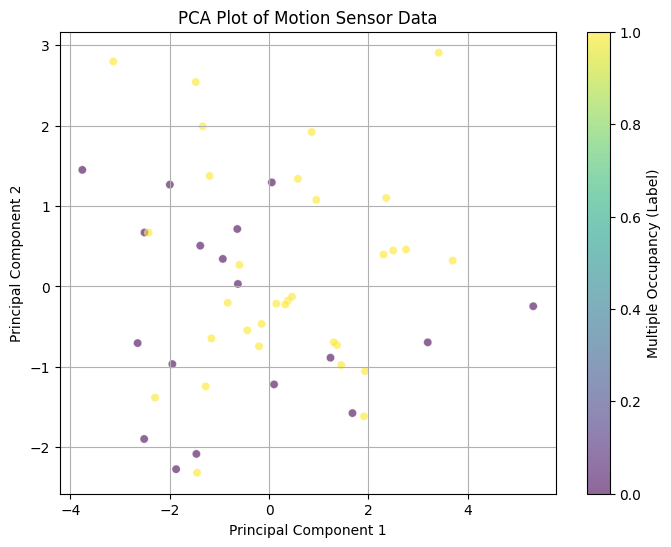

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Separate features and target
X = features_df.drop(columns=['home_id', 'multiple_occupancy'])  # Exclude the identifier and target label
y = features_df['multiple_occupancy']  # Target variable

# Standardising the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(X_scaled)

# Creating a DataFrame with the 2 principal components
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# Concatenate the prediction labels for coloring the points
pca_df = pd.concat([pca_df, y.reset_index(drop=True)], axis=1)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'],
                      c=pca_df['multiple_occupancy'], alpha=0.6, cmap='viridis', edgecolors='w', linewidths=0.5)
plt.title('PCA Plot of Motion Sensor Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Multiple Occupancy (Label)')
plt.grid(True)
plt.show()
